In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import json
from sklearn.linear_model import LogisticRegression

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from scipy.stats import pearsonr
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from typing import Literal

In [5]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# Import Data

In [6]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)
data.shape

(1652, 44)

In [7]:
def replace_data(df):
    df.replace('N', np.nan, inplace=True)
    return df

In [8]:
column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

# Copy the initial dataset to apply transformations
def choose_labels(df, labels_chosen):
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()  
    
    # Initialize new columns
    df.loc[:, "Hardness_load"] = np.nan
    df.loc[:, "Nitrogen_concentration_residual"] = 0
    
    # Select the chosen labels
    labels = df[labels_chosen]
    
    # Drop specified columns
    inputs = df.drop(columns=label_names + ['Weld_ID'])
    
    return inputs, labels

data_copy = data.copy()
data_copy= replace_data(data_copy)
inputs, outputs = choose_labels(df=data_copy, labels_chosen="Yield_strength")

# Infos

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Carbon_concentration                  1652 non-null   float64
 1   Silicon_concentration                 1652 non-null   float64
 2   Manganese_concentration               1652 non-null   float64
 3   Sulphur_concentration                 1652 non-null   object 
 4   Phosphorus_concentration              1652 non-null   object 
 5   Nickel_concentration                  1652 non-null   object 
 6   Chromium_concentration                1652 non-null   object 
 7   Molybdenum_concentration              1652 non-null   object 
 8   Vanadium_concentration                1652 non-null   object 
 9   Copper_concentration                  1652 non-null   object 
 10  Cobalt_concentration                  1652 non-null   object 
 11  Tungsten_concentr

# Data Cleaning

## Structural Errors

In [10]:
# Visualisation of the different data
i = 0
for column in data.columns:
    print(i)
    print(column)
    print(data[column].unique())
    i+=1

0
Carbon_concentration
[0.037  0.044  0.045  0.039  0.041  0.051  0.049  0.038  0.043  0.053
 0.046  0.048  0.074  0.075  0.076  0.068  0.081  0.079  0.078  0.069
 0.08   0.071  0.072  0.066  0.067  0.09   0.088  0.091  0.089  0.094
 0.086  0.04   0.047  0.052  0.05   0.054  0.073  0.077  0.07   0.062
 0.06   0.055  0.059  0.042  0.058  0.065  0.095  0.151  0.147  0.145
 0.061  0.035  0.1    0.12   0.099  0.093  0.101  0.096  0.097  0.03
 0.032  0.031  0.098  0.13   0.11   0.057  0.15   0.064  0.082  0.036
 0.125  0.105  0.115  0.1055 0.14   0.16   0.084  0.092  0.029  0.063
 0.18  ]
1
Silicon_concentration
[0.3   0.31  0.35  0.33  0.32  0.36  0.29  0.34  0.39  0.44  0.48  0.37
 0.51  0.57  0.27  0.45  0.24  0.41  0.46  0.43  0.42  0.52  0.54  0.18
 0.17  0.2   0.22  0.4   0.26  0.25  0.53  0.38  0.28  0.47  0.23  0.16
 0.62  0.68  0.59  0.7   0.56  0.5   0.58  0.66  0.63  0.67  0.61  0.21
 0.49  0.12  0.13  0.15  0.11  0.19  0.14  0.415 0.08  0.04  0.07  0.55
 0.9   0.8   1.14  0.95  

- Values < N: choose a random number < N, set the value to N
- Hardness: Cases like 158(Hv30) means a hardness of 158, measured with a 30 kgf load. When it is not specified, it means a default value was used.
- Nitrogen_concentration: Cases like '67tot33res' --> only use the part '67', split in two categories, one for '67' and one for '33'.
- Interpass_temperature: Cases like '150-200' means between 150 and 200

In [11]:
#Handle particular format of data

def sum_values_inferior_to_value(data):
    # Dictionary to store for each the maximum value of the column sum_less_than
    mean_values = {}
    values = data.unique()
    for value in values:
        mean_values[value] = data[data <= value].sum() / data[data <= value].shape[0]
    
    return mean_values


# Values < N
def replace_less_than_values(*, df, column, strategy: Literal['max', 'mean']):
    if df[column].any() and type(df[column].dropna().iloc[0]) == str:  # Check if the column contains string values:
        new_column = column + '_<'  # Create a new column name
        df[new_column] = np.nan  # Create a new column to store the boolean values
        
        # Apply the transformation using .loc to avoid SettingWithCopyWarning
        mask = df[column].apply(lambda x: isinstance(x, str))
        df.loc[mask, column + '_<'] = df.loc[mask, column].str.contains('<')
        df.loc[mask, column] = df.loc[mask, column].replace('<', '', regex=True)
        
        if strategy=='max':
            # Replace the values in the column by the max value
            df.loc[df[new_column] == True, column] = df.loc[df[new_column] == True, column].apply(lambda x: float(x))
        elif strategy=='mean' and df.loc[df[new_column] == True, column].shape[0] > 0:
            # Replace the values in the column by the mean value of the values inferior to max value
            mean_values = sum_values_inferior_to_value(df.loc[df[column].notna(), column].apply(lambda x: float(x)))
            df.loc[df[new_column] == True, column].map(mean_values)

        df.drop(column + '_<', axis=1, inplace=True)
    return df

# Values like 158(Hv30) or 67tot33res
def split_res_values(value, pattern):
    if isinstance(value, str) and pattern in value:
        # Looking for two numbers in the string 
        numbers = re.findall(r'\d+', value)
        if len(numbers) > 1:
            return float(numbers[0]), float(numbers[1])
        else:
            return float(numbers[0]), np.nan  # If only one number is before "res"
    else:
        try:
            return float(value), np.nan  # If there is no "res", return NaN
        except ValueError:
            return np.nan, np.nan

# Values like 150 - 200
def process_interpass_temperature(value):
        if isinstance(value, str) and '-' in value:
            # Split the range, convert to integers, and calculate the mean
            low, high = map(int, value.split('-'))
            return int((low + high) / 2)
        else:
            # Try converting the value to int, or return NaN if not possible
            try:
                return int(value)
            except (ValueError, TypeError):
                return np.nan
            
# Handling columns with two numerical values 
def process_string_values(*, inputs, outputs, strategy, labels_chosen):
    for column in inputs.columns:
        inputs = replace_less_than_values(df=inputs, column=column, strategy=strategy)
    inputs['Nitrogen_concentration'], inputs['Nitrogen_concentration_residual'] =  zip(*inputs['Nitrogen_concentration'].apply(lambda x:split_res_values(x, 'res')))
    if 'Hardness' in labels_chosen:
        outputs['Hardness'], outputs['Hardness_load'] =  zip(*outputs['Hardness'].apply(lambda x:split_res_values(x, 'Hv')))
    inputs['Interpass_temperature'] = inputs['Interpass_temperature'].apply(process_interpass_temperature)
    return inputs, outputs

#data_copy, _ = process_string_values(inputs=inputs, outputs=outputs, strategy='random', labels_chosen="Yield_strength")

In [12]:
# Converting string values that are actually numeric
def convert_to_numeric_values(df):
    for column in data.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except Exception:
            continue
    return df


# data_copy = convert_to_numeric_values(data_copy)
# print(data_copy.info())
# data_copy.head

## Imputation of missing values

### Concentrations: P (Phosphorus) and S (Sulfur) with mean values

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
Phosphorus and sulfur are usually present in steel, even if they aren't deliberately added. These elements are often impurities, and their concentrations are small but non-zero in most cases. When their values are missing in the data, the assumption is that they were not measured but still exist at some average level. Thus, the authors use the mean concentration as a reasonable estimate for missing values.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [13]:
# Instantiate a transformer for mean imputation.
def missing_values_sulphur_and_phosphorus(df_train, df_test):

    imp_mean = SimpleImputer(strategy='mean')
    df_train[sulphur_and_phosphorus_columns] = imp_mean.fit_transform(df_train[sulphur_and_phosphorus_columns])
    df_test[sulphur_and_phosphorus_columns] = imp_mean.transform(df_test[sulphur_and_phosphorus_columns])

    return df_train, df_test

#data_copy = missing_values_sulphur_and_phosphorus(data_copy)

### Other concentrations (e.g., Mn, Ni, etc.) by setting them to 0

<div class="alert alert-block alert-success">
<b>Why to do this ?</b>
These elements are typically added to modify the properties of the steel (e.g., adding Mn for strength, Ni for corrosion resistance). If their concentrations aren't reported in the dataset, the assumption is that these elements were not added intentionally. Since deliberate alloying additions would typically be measured and reported, the absence of data implies that the element is likely present only at trace levels (so very close to zero). This assumption comes from the fact that modern chemical analysis techniques can detect very low concentrations, so if no value was reported, the concentration is negligible.

**Source**:
Source: The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b 
</div>

In [14]:
def missing_values_other_concentration(df_train, df_test):

    # Initialize SimpleImputer with constant strategy to fill missing values with 0
    imputer_zero = SimpleImputer(strategy='constant', fill_value=0)
    df_train[other_concentration_columns] = imputer_zero.fit_transform(df_train[other_concentration_columns])
    df_test[other_concentration_columns] = imputer_zero.transform(df_test[other_concentration_columns])

    return df_train, df_test

#data_copy = missing_values_other_concentration(data_copy)
#data_copy[other_concentration_columns].info()


### Electrical and mechanical properties

<div class="alert alert-block alert-success">
We treat the other features with univariate or multivariate approaches
</div>

In [15]:
#Functions to handle electrical and mechanical properties imputations

def univariate_imputation(train_data, test_data, strategy):
    # Create a SimpleImputer object with the specified strategy
    imp = SimpleImputer(strategy=strategy)
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed

def multivariate_imputation_ordinal(train_data, test_data):
    # Create an IterativeImputer for ordinal imputation
    imp = IterativeImputer()
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed

def multivariate_imputation_categorical(train_data, test_data):
    # Create an IterativeImputer for categorical imputation with a logistic regression estimator
    imp = IterativeImputer(estimator=LogisticRegression())
    # Fit the imputer on the training data and transform it
    train_imputed = imp.fit_transform(train_data)
    # Transform the test data using the same imputer
    test_imputed = imp.transform(test_data)
    return train_imputed, test_imputed


def one_hot_encoding(training_set, testing_set):
    # Store ordinal columns
    ordinal_columns = training_set.select_dtypes(include=[np.number]).columns
    
    # One Hot Encoding on the training_set without dummy_na
    training_encoded = pd.get_dummies(training_set, drop_first=False, dummy_na=True, dtype=float)
    
    # Get the final columns of the training_set
    final_columns = training_encoded.columns

    # Handle NaN values manually
    for column in final_columns:
        if '_nan' in column:
            dummy_columns = [col for col in final_columns if col.startswith(column[:-4])]
            for dummy_col in dummy_columns:
                training_encoded.loc[training_encoded[column] == 1, dummy_col] = np.nan
            training_encoded.drop(column, axis=1, inplace=True)

    # Apply the same One-Hot Encoding to the testing_set
    testing_encoded = pd.get_dummies(testing_set, drop_first=False, dummy_na=True, dtype=float)

    # Ensure that the testing_set has the same columns as the training_set
    # Align the columns of testing_encoded to those of training_encoded
    testing_encoded = testing_encoded.reindex(columns=final_columns, fill_value=0)

    # Final columns after encoding
    final_columns = training_encoded.columns

    # New categorical columns
    new_categorical_columns = list(set(final_columns) - set(ordinal_columns))

    return training_encoded, testing_encoded, new_categorical_columns

def missing_values_physical_properties(train_data, test_data, ordinal_strategy, categorical_strategy, categorical_columns):
    # Distinguish ordinal columns
    ordinal_columns = train_data.columns.difference(categorical_columns)
    
    # Impute ordinal values
    if len(ordinal_columns) > 0:
        if ordinal_strategy == 'mean':
            # Replace missing values with the mean value
            train_data[ordinal_columns], test_data[ordinal_columns] = univariate_imputation(train_data[ordinal_columns], test_data[ordinal_columns], 'mean')
        elif ordinal_strategy == 'linear':
            # Replace missing values with a linear regression
            train_data[ordinal_columns], test_data[ordinal_columns] = multivariate_imputation_ordinal(train_data[ordinal_columns], test_data[ordinal_columns])

    # Impute categorical values
    if len(categorical_columns) > 0:
        if categorical_strategy == 'most_frequent':
            # Replace missing values with the most frequent value
            train_data[categorical_columns], test_data[categorical_columns] = univariate_imputation(train_data[categorical_columns], test_data[categorical_columns], 'most_frequent')
        elif categorical_strategy == 'logistic':
            # Replace missing values with a logistic regression
            train_data[categorical_columns], test_data[categorical_columns] = multivariate_imputation_categorical(train_data[categorical_columns], test_data[categorical_columns])
    
    return train_data, test_data

#After the one hot encoding and the imputation, we need to be sure that the data that has been imputed respects the incompatibility rule (either AC or DC etc...)

def handle_incompatibility_categorical_features(df, incompatible_features_list):
    
    for incompatible_features in incompatible_features_list:
        # Check the rows where all specified columns are equal to zero
        zero_rows = df.index[df[incompatible_features].sum(axis=1) == 0]

        # Check the rows where there is more than one '1' in the specified columns
        more_one_rows = df.index[df[incompatible_features].sum(axis=1) > 1]

        # For the rows where all the specified columns are zero
        for idx in zero_rows:
            # Randomly select one of the incompatible features
            random_col = np.random.choice(incompatible_features)
            # Set the selected column to 1 for the current index
            df.at[idx, random_col] = 1  

        # For the rows where there is more than one '1'
        for idx in more_one_rows:
            # Get the columns that have a value of '1' for the current index
            columns_with_one = df.columns[df.loc[idx] == 1]  # Corrected here
            
            # Ensure there are columns with '1'
            if len(columns_with_one) > 0:
                # Randomly select one of the columns with '1'
                random_col = np.random.choice(columns_with_one)
                # Set all columns with '1' to 0 for the current index
                df.loc[idx, columns_with_one] = 0
                # Set the randomly selected column back to 1 for the current index
                df.at[idx, random_col] = 1  

    return df


# Data Transformation

## Normalisation of the data

In [16]:
#We need to normalise the data before the PCA

from typing import Literal
from sklearn.preprocessing import Normalizer, StandardScaler

def scaler(train_df: pd.DataFrame, test_df: pd.DataFrame, columns_to_normalise: list, strategy: Literal['standard', 'normalizer']):
    if strategy == 'standard':
        # Instantiate a StandardScaler
        scaler = StandardScaler()
    elif strategy == 'normalizer':
        # Instantiate a Normalizer
        scaler = Normalizer()
    else:
        raise ValueError("Invalid strategy. Choose either 'standard' or 'normalizer'.")

    # Fit the scaler only on the categorical columns of the training data
    train_scaled = scaler.fit_transform(train_df[columns_to_normalise])
    test_scaled = scaler.transform(test_df[columns_to_normalise])

    # Convert the normalized data to DataFrames
    train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_normalise, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_normalise, index=test_df.index)

    # Combine scaled categorical columns with the original DataFrames (excluding the original categorical columns)
    train_final = pd.concat([train_df.drop(columns=columns_to_normalise), train_scaled_df], axis=1)
    test_final = pd.concat([test_df.drop(columns=columns_to_normalise), test_scaled_df], axis=1)

    return train_final, test_final

##  Reduction of dimension

C:\Users\camil\AppData\Local\Temp\ipykernel_25080\614187911.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_copy[concentration_columns].corr() # By default it is pearson correlation


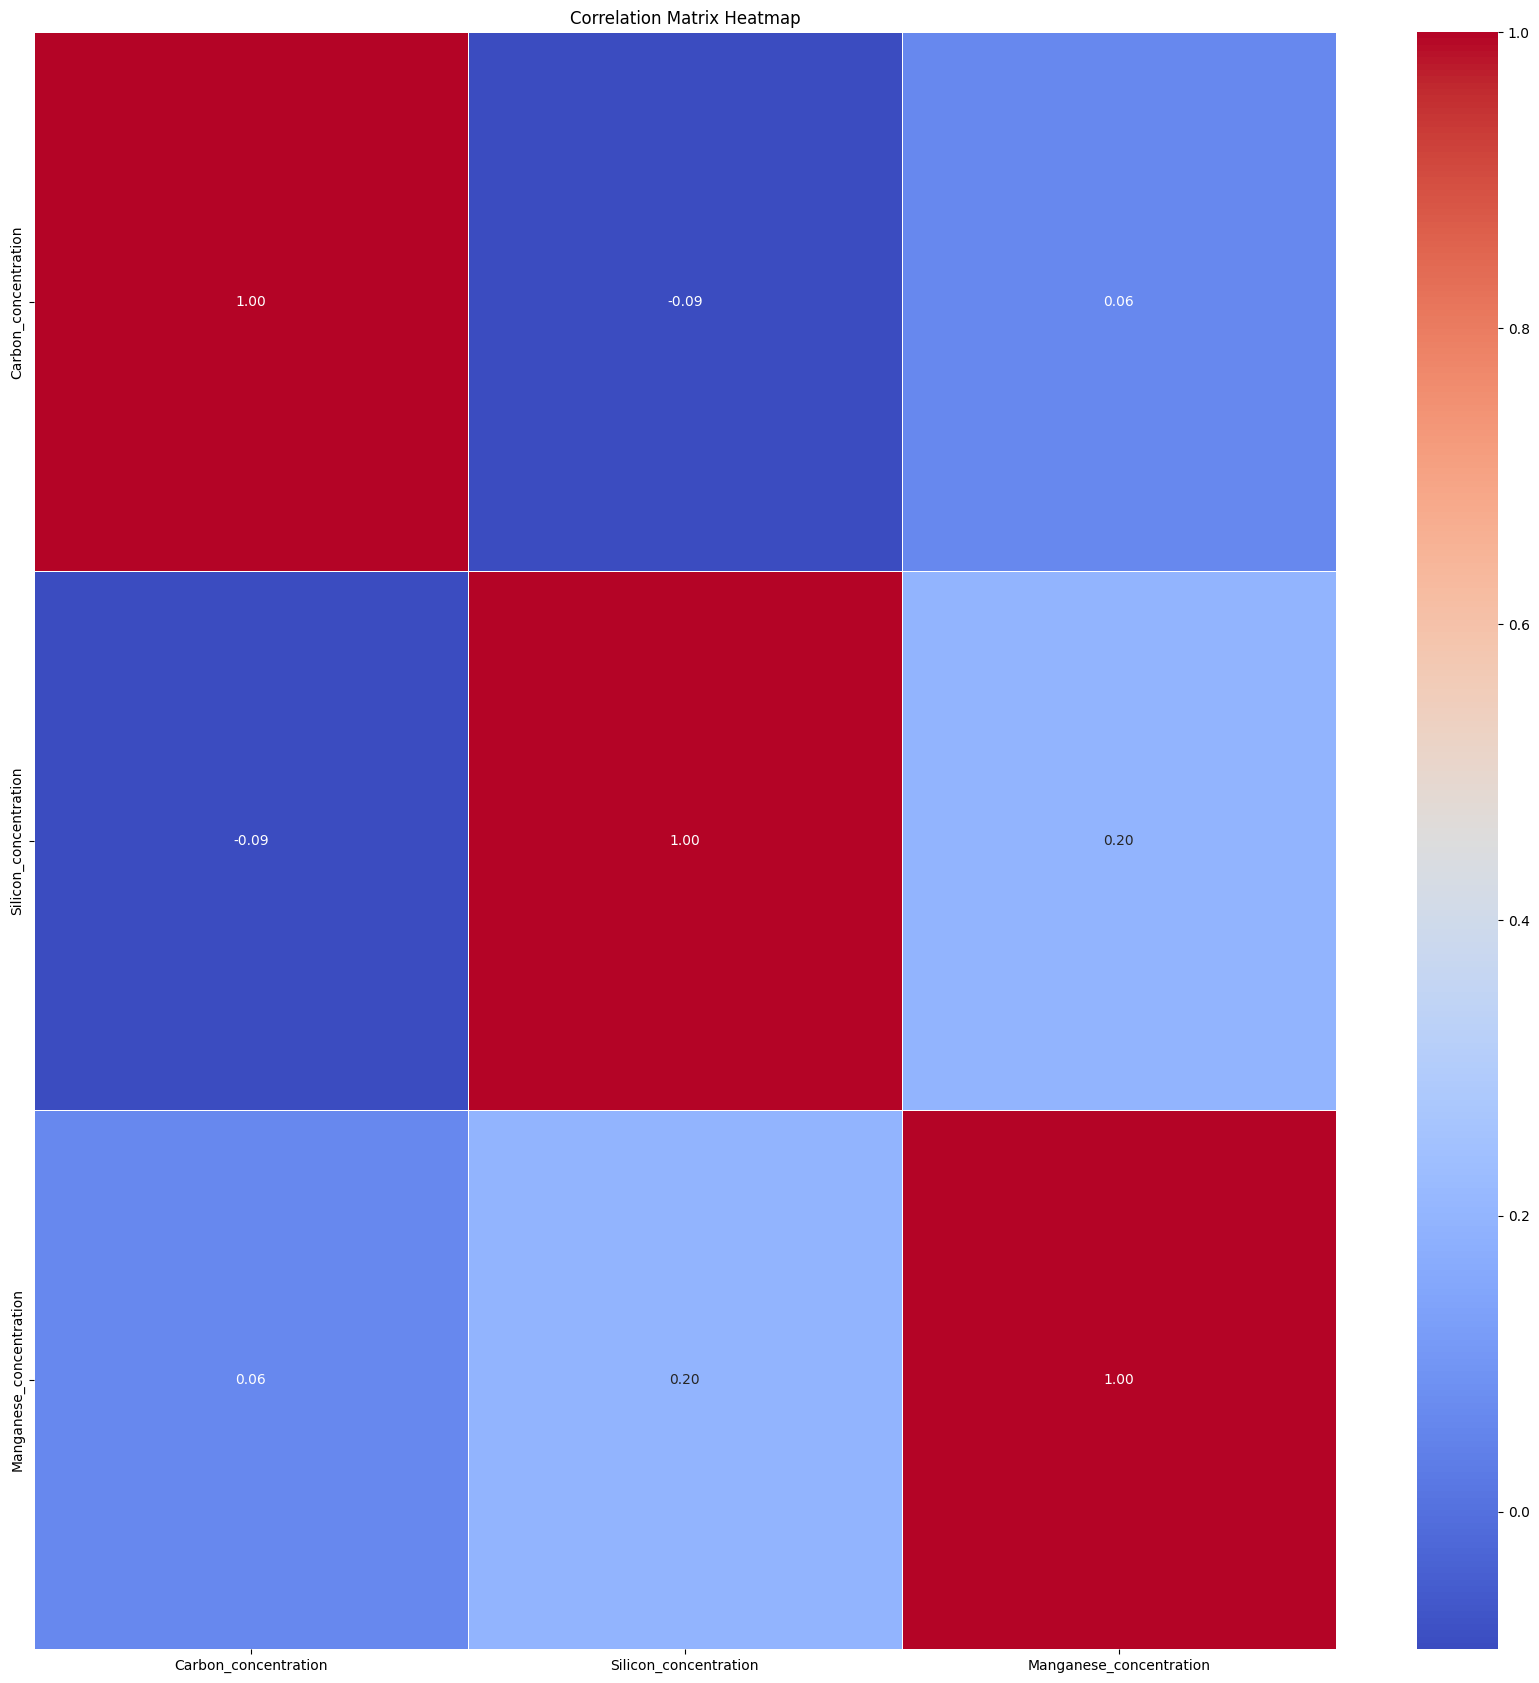

In [17]:
concentration_columns = column_names[0: 21]
correlation_matrix = data_copy[concentration_columns].corr() # By default it is pearson correlation
plt.figure(figsize=(21, 21))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<div class="alert alert-block alert-info">

- Phosphorus and Sulphur concentrations are deeply correlated

- Molybdenum and Chromimum concentrations are correlated 

The rest seems to be not so much correlated. Maybe we can use a PCA approach to reduce the number of features

According to sckit-learn library, we can use PCA with n_components=0.80 and svd_solver="full"

<b> "If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components."</b>

svd_solver = "full" means exact full SVD computes all possible singular values and vectors of the data matrix, even if they might not be needed
</div>

In [18]:
# PCA on the data

def compute_pca(train_df, test_df, pca_percent_explained_variance):
    # PCA approach
    pca = PCA(n_components=pca_percent_explained_variance, svd_solver="full")

    # Fit PCA on the training DataFrame and transform the data
    train_concentration_vector = pca.fit_transform(train_df)

    # Transform the test DataFrame using the fitted PCA model
    test_concentration_vector = pca.transform(test_df)

    # Results
    explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
    n_components = pca.n_components_  # Number of components chosen to explain the specified variance
    
    # Convert the transformed data back to DataFrames, keeping the original index
    train_concentration_data = pd.DataFrame(train_concentration_vector, 
                                            columns=[f'PC{i+1}' for i in range(n_components)],
                                            index=train_df.index)  # Preserve original index
    test_concentration_data = pd.DataFrame(test_concentration_vector, 
                                           columns=[f'PC{i+1}' for i in range(n_components)],
                                           index=test_df.index)  # Preserve original index

    # Print results
    print(f"Number of components chosen by PCA: {n_components}")
    print(f"Explained Variance Ratio: {explained_variance_ratio}")

    return train_concentration_data, test_concentration_data


# Pipeline

In [19]:
OrdinalStrategies = Literal["mean", "linear"]
CategoricalStrategies = Literal["most_frequent", "logistic"]
ScalerStrategy = Literal["standard", "normalizer"]
incompatible_features_list = [['AC_or_DC_DC', 'AC_or_DC_AC'], ['Electrode_positive_or_negative_+', 'Electrode_positive_or_negative_0', 'Electrode_positive_or_negative_-'], ['Type_of_weld_MMA', 'Type_of_weld_ShMA', 'Type_of_weld_FCA', 'Type_of_weld_SA', 'Type_of_weld_TSA', 'Type_of_weld_SAA', 'Type_of_weld_GTAA', 'Type_of_weld_GMAA', 'Type_of_weld_NGSAW', 'Type_of_weld_NGGMA']
]
PcaColumns = Literal['concentration', 'all_ordinals']
LessThanList = Literal['max', 'mean']


def pipeline_training_set(*, training_set: pd.DataFrame, training_labels : pd.DataFrame, testing_set: pd.DataFrame, 
                          testing_labels : pd.DataFrame, labels_chosen : list[str], is_PCA: bool, pca_percent_explained_variance: float, 
                          ordinal_strategy: OrdinalStrategies, categorical_strategy: CategoricalStrategies, scaler_strategy: ScalerStrategy,
                          pca_columns: PcaColumns, less_than_strategy: LessThanList):
    

    # Structural errors
    training_set, training_labels = process_string_values(inputs=training_set, outputs=training_labels, labels_chosen=labels_chosen, 
                                                          strategy=less_than_strategy)
    testing_set, testing_labels = process_string_values(inputs=testing_set, outputs=testing_labels, labels_chosen=labels_chosen, 
                                                        strategy=less_than_strategy)

    training_set = convert_to_numeric_values(training_set)
    testing_set = convert_to_numeric_values(testing_set)


    # Missing values
    ## Transform concentrations accordingly to 
    ## "The yield and ultimate tensile strength of steel welds - Tracey Cool a,*, H.K.D.H. Bhadeshia a, D.J.C. MacKay b"
    training_set, testing_set = missing_values_sulphur_and_phosphorus(training_set, testing_set)
    training_set, testing_set = missing_values_other_concentration(training_set, testing_set)

    # One Hot Encoding
    training_set, testing_set, categorical_columns = one_hot_encoding(training_set, testing_set)

    # Missing values
    training_set, testing_set = missing_values_physical_properties(training_set, testing_set, ordinal_strategy=ordinal_strategy, categorical_strategy=categorical_strategy, categorical_columns=categorical_columns)
    
    # Handle the incompatibility concerning the imputation of some categorical values
    training_set = handle_incompatibility_categorical_features(training_set, incompatible_features_list)
    testing_set = handle_incompatibility_categorical_features(testing_set, incompatible_features_list)


    # Normalisation
    columns_to_normalise = physical_ordinal_properties_columns + sulphur_and_phosphorus_columns + other_concentration_columns
    training_set_normalised, testing_set_normalised = scaler(training_set, testing_set, columns_to_normalise, strategy=scaler_strategy)


    # Dimension reduction
    if pca_columns == 'concentration':
        pca_columns_list = sulphur_and_phosphorus_columns + other_concentration_columns
        other_columns = physical_ordinal_properties_columns + categorical_columns
        pca_data_training = training_set_normalised[pca_columns_list]
        pca_data_testing = testing_set_normalised[pca_columns_list]
    elif pca_columns == 'all_ordinals':
        pca_columns_list = sulphur_and_phosphorus_columns + other_concentration_columns + physical_ordinal_properties_columns
        other_columns = categorical_columns
        pca_data_training = training_set_normalised[pca_columns_list]
        pca_data_testing = testing_set_normalised[pca_columns_list]

    if is_PCA:
        # Call the PCA function with both training and testing datasets
        train_concentration_data, test_concentration_data = compute_pca(
            pca_data_training, pca_data_testing, pca_percent_explained_variance
        )        

        # Combine the PCA results with the training set
        training_set_processed = pd.concat(
            [train_concentration_data, training_set[other_columns]], 
            axis=1
        )
        
        # Combine the PCA results with the testing set
        testing_set_processed = pd.concat(
            [test_concentration_data, testing_set[other_columns]], 
            axis=1
        )
    
    # Return processed training set and labels
    return training_set_processed, testing_set_processed, training_labels, testing_labels


# Training of the models

## Preparation of the data

In [20]:
from sklearn.model_selection import train_test_split
import warnings

# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)

# Split of the data in train and test

In [41]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                         labels_chosen=labels_selected, categorical_strategy="logistic", \
                                                        ordinal_strategy="linear", is_PCA=True, pca_percent_explained_variance=0.85, 
                                                        scaler_strategy="standard", pca_columns="all_ordinals", less_than_strategy="mean")

Number of components chosen by PCA: 16
Explained Variance Ratio: [0.14477592 0.13050565 0.07542379 0.06764044 0.0595773  0.04859654
 0.04364692 0.03880992 0.03703142 0.03531551 0.03306723 0.03077799
 0.02981294 0.02866044 0.02604628 0.02529916]


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [43]:
y_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE :", rmse)

RMSE : 76.6572881885838
